In [1]:
from ioi_utils import *
from circuit_utils import *
from sae_variants import *
from sae_interp import *
from sae_interventions import *
from training import *
from mandala._next.imports import *
from mandala._next.common_imports import *

# Circuit setup

In [2]:
from circuit_utils import *
torch.set_printoptions(sci_mode=False)
if 'model' in locals():
    MODELS[MODEL_ID] = model

HEAD_CLASS_FIG = {
    'nm': 'Name Mover',
    'bnm': 'Backup Name Mover',
    'ind': 'Induction',
    'nnm': 'Negative Name Mover',
    'si': 'S-Inhibition',
    'dt': 'Duplicate Token',
    'pt': 'Previous Token',
}

COMPONENT_NAME_FIG = {
    'k': 'Key',
    'v': 'Value',
    'q': 'Query',
    'z': 'Attn Output',
}

CROSS_SECTION_FIG = {
    'ind+dt@z': 'Ind+DT out',
    'nm+bnm@q': '(B)NM q',
    'nm+bnm@qk': '(B)NM qk',
    'nm+bnm@z': '(B)NM out',
    'si@v': 'S-I v',
    'si@z': 'S-I out',
}

c = Circuit()
paper_cross_sections = [
    # IO
    (c.zs(c.nm + c.bnm), ('io',), 'nm+bnm@z'),
    # (c.qs(c.nm + c.bnm) + c.ks(c.nm + c.bnm), ('io',), 'nm+bnm@qk'),
    # (c.qs(c.nm + c.bnm), ('io',), 'nm+bnm@q'),
    # # S
    # (c.qs(c.nm + c.bnm) + c.ks(c.nm + c.bnm), ('s',), 'nm+bnm@qk'),
    # (c.qs(c.nm + c.bnm), ('s',), 'nm+bnm@q'),
    # (c.vs(c.si), ('s',), 'si@v'),
    # (c.zs(c.si), ('s',), 'si@z'),
    # (c.zs(c.ind) + c.zs(c.dt), ('s',), 'ind+dt@z'),
    # Pos
    (c.qs(c.nm + c.bnm) + c.ks(c.nm + c.bnm), ('io_pos',), 'nm+bnm@qk'),
    (c.qs(c.nm + c.bnm), ('io_pos',), 'nm+bnm@q'),
    (c.zs(c.si), ('io_pos',), 'si@z'),
    (c.vs(c.si), ('io_pos',), 'si@v'),
    (c.zs(c.ind) + c.zs(c.dt), ('io_pos',), 'ind+dt@z'),
    # # Pos + S
    # (c.qs(c.nm + c.bnm) + c.ks(c.nm + c.bnm), ('io_pos', 's'), 'nm+bnm@qk'),
    # (c.zs(c.si), ('io_pos', 's'), 'si@z'),
    # (c.vs(c.si), ('io_pos', 's'), 'si@v'),
    # (c.zs(c.ind) + c.zs(c.dt), ('io_pos', 's'), 'ind+dt@z'),
    # # All
    # (c.qs(c.nm + c.bnm) + c.ks(c.nm + c.bnm), ('io', 'io_pos', 's'), 'nm+bnm@qk'),
]

locations_displaynames = {
    'nm+bnm@z': '(B)NM out',
    'nm+bnm@qk': '(B)NM qk',
    'nm+bnm@q': '(B)NM q',
    'si@v': 'S-I v',
    'si@z': 'S-I out',
    'ind+dt@z': 'Ind+DT out',
}

NODES = c.zs(c.nm + c.bnm) + c.qs(c.nm + c.bnm) + c.zs(c.si) + [n for n in c.vs(c.si) if n.seq_pos == 's2'] + c.zs(c.ind) + c.zs(c.dt) + c.ks(c.nm + c.bnm)

NODE_TO_HEADS_CLASS = {}
for nodes, _, heads_class in paper_cross_sections:
    for node in nodes:
        NODE_TO_HEADS_CLASS[node] = heads_class

DISPLAYNAME_TO_NODE = {node.displayname: node for node in NODES}

HEAD_CLASSES_IO = [heads_class for _, features, heads_class in paper_cross_sections if features[0] == 'io']
HEAD_CLASSES_POS = [heads_class for _, features, heads_class in paper_cross_sections if features[0] == 'io_pos']

supervised_df = pd.read_csv('supervised_editing_full_df.csv')
NODES_TO_HEADS_CLASS = supervised_df[['nodes_to_edit', 'heads_class']].set_index('nodes_to_edit').to_dict()['heads_class']

CROSS_SECTION_FIG = {
    'ind+dt@z': 'Ind+DT out',
    'nm+bnm@q': '(B)NM q',
    'nm+bnm@qk': '(B)NM qk',
    'nm+bnm@z': '(B)NM out',
    'si@v': 'S-I v',
    'si@z': 'S-I out',
}

def get_location(
        nodes_to_edit, attribute
) -> str:
    heads_class = NODES_TO_HEADS_CLASS[nodes_to_edit]
    cross_section_name = CROSS_SECTION_FIG[heads_class]
    if attribute == 'io': attr = 'IO'
    if attribute == 'io_pos': attr = 'Pos'
    return f'{attr} in {cross_section_name}'

could not find model


In [3]:
DB_PATH = '/media/amakelov/SanDisk1TB/paper_sprint/test.db'

In [4]:
storage = Storage(db_path=DB_PATH)

In [5]:
model = get_model()
MODELS[MODEL_ID] = model

/home/amakelov/workspace/current/conda_envs/serimats/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


# Preparing datasets

In [6]:
from mandala._next.model import Context

In [7]:
# nodes = list(c.nodes.keys())
# circuit_nodes = list(c.nodes.keys())

with storage:

    ############################################################################ 
    ### prompt dataset for training supervised features
    ############################################################################ 
    P_train = generate_prompts(
        distribution=full_distribution,
        patterns=['ABB', 'BAB'],
        prompts_per_pattern=10_000,
        random_seed=0,
    )
    N_TRAIN = len(storage.unwrap(P_train))
    ### activations for training supervised features
    As_train = run_with_cache(
        prompts=P_train, 
        nodes=NODES,
        batch_size=100,
        model_id=MODEL_ID,
        verbose=True,
    )
    A_TRAIN_DICT = {node: A for node, A in zip(NODES, As_train)}

    # ### precompute the mean logit difference for clean training data
    # logits_train_clean = run_with_hooks(prompts=P_train, hooks=[], batch_size=200,)
    # CLEAN_LD_MEAN = (storage.unwrap(logits_train_clean)[:, 0] - storage.unwrap(logits_train_clean)[:, 1]).mean().item()

    # ### precompute the mean-ablated logit difference when ablating each node
    # A_TRAIN_MEAN_DICT = {node: get_dataset_mean(A) for node, A in A_TRAIN_DICT.items()}

    # MEAN_ABLATED_LD_DICT = {}
    # for node, A in A_TRAIN_DICT.items():
    #     MEAN_ABLATED_LD_DICT[node] = compute_mean_ablated_lds(
    #         node=node, prompts=P_train, A_mean=A_TRAIN_MEAN_DICT[node], batch_size=200,
    #     )

    ############################################################################ 
    ### prompt dataset for editing and other evaluations
    ############################################################################ 
    N_NAMES = len(NAMES)
    editing_base_distribution = copy.deepcopy(full_distribution)
    editing_base_distribution.names = editing_base_distribution.names[:N_NAMES // 2]
    editing_source_distribution = copy.deepcopy(full_distribution)
    editing_source_distribution.names = editing_source_distribution.names[N_NAMES // 2:]

    P_eval = generate_prompts(
        distribution=editing_base_distribution,
        patterns=['ABB', 'BAB'],
        prompts_per_pattern=2500,
        random_seed=1,
    )
    As_eval = run_with_cache(
        prompts=P_eval, 
        nodes=NODES,
        batch_size=100,
        model_id=MODEL_ID,
        verbose=True,
    )
    P_eval_feature_idxs = get_prompt_feature_idxs(
        prompts=P_eval,
        features=[('io',), ('s',), ('io_pos',),],
    )
    A_EVAL_DICT = {node: A for node, A in zip(NODES, As_eval)}

    N_EVAL = len(storage.unwrap(P_eval))
    N_NAMES_EVAL_SOURCE = len(editing_source_distribution.names)

    ### precompute the mean logit difference for clean training data
    logits_eval_clean = run_with_hooks(prompts=P_eval, hooks=[], batch_size=200,)
    CLEAN_LD_EVAL_MEAN = (storage.unwrap(logits_eval_clean)[:, 0] - storage.unwrap(logits_eval_clean)[:, 1]).mean().item()

    ### precompute the mean-ablated logit difference when ablating each node
    A_EVAL_MEAN_DICT = {node: get_dataset_mean(A) for node, A in A_EVAL_DICT.items()}

    MEAN_ABLATED_LD_EVAL_DICT = {}
    for node, A in A_EVAL_DICT.items():
        MEAN_ABLATED_LD_EVAL_DICT[node] = compute_mean_ablated_lds(
            node=node, prompts=P_eval, A_mean=A_EVAL_MEAN_DICT[node], batch_size=200,
        )

    ############################################################################ 
    ### Compute counterfactual prompts and activations
    ############################################################################ 
    ATTRIBUTES = [('io_pos',), ('s',), ('io',), ] # ('s', 'io_pos',), ('io', 'io_pos'), ('s', 'io',), ('io_pos', 's', 'io',), ]

    CF_PROMPTS_DICT = {}
    for attribute in ATTRIBUTES:
        CF_PROMPTS_DICT[attribute] = get_cf_prompts(
            prompts=P_eval, 
            features=attribute,
            io_targets=generate_name_samples(N_EVAL, editing_source_distribution.names[:N_NAMES_EVAL_SOURCE // 2]),
            s_targets=generate_name_samples(N_EVAL, editing_source_distribution.names[N_NAMES_EVAL_SOURCE//2:]),     
        )
    ### Compute counterfactual activations
    A_EVAL_CF_DICT = {}
    for attribute, cf_prompts in tqdm(CF_PROMPTS_DICT.items()):
        A_EVAL_CF_DICT[attribute] = run_with_cache(
            prompts=cf_prompts, 
            nodes=NODES,
            batch_size=100,
            model_id=MODEL_ID,
            verbose=True,
        )
    for attribute in A_EVAL_CF_DICT:
        A_EVAL_CF_DICT[attribute] = {node: A_EVAL_CF_DICT[attribute][i] for i, node in enumerate(NODES)}
    
    P_eval_cf_feature_idxs = {}
    for attribute, cf_prompts in CF_PROMPTS_DICT.items():
        P_eval_cf_feature_idxs[attribute] = get_prompt_feature_idxs(
            prompts=cf_prompts,
            features=[attribute],
        )

100%|██████████| 3/3 [00:00<00:00, 14.66it/s]


### Gradient collection

In [8]:
P_TRAIN_GRADIENTS = get_gradients(storage=storage, nodes=NODES, prompts=P_train, computing=False, n_batches=100)
P_EVAL_GRADIENTS = get_gradients(storage=storage, nodes=NODES, prompts=P_eval, computing=False, n_batches=25)
P_CF_GRADIENTS = {}
for attribute in ATTRIBUTES:
    P_CF_GRADIENTS[attribute] = get_gradients(storage=storage, nodes=NODES, prompts=CF_PROMPTS_DICT[attribute], computing=False, n_batches=25)

100%|██████████| 25/25 [00:02<00:00, 12.20it/s]


# Choosing SAEs to use for editing

In [9]:
SAES_DICT = joblib.load('SAES_DICT.joblib') # (variant, node, l1, end_epoch) -> encoder
EDITED_INTERP_DICT = joblib.load('EDITED_INTERP_DICT.joblib') # (variant, node, l1, end_epoch, attribute, num_exchange) -> A_edited
EDITED_AGNOSTIC_DICT = joblib.load('EDITED_AGNOSTIC_DICT.joblib') # (variant, node, l1, end_epoch, attribute, num_exchange) -> A_edited
WEIGHT_REMOVED_DICT = joblib.load('WEIGHT_REMOVED_DICT.joblib') 
# merge into 1 edit dict
EDITED_DICT = {} # keys will be (variant, node, l1, end_epoch, attribute, num_exchange, edit_type)
for k, v in EDITED_INTERP_DICT.items():
    EDITED_DICT[k + ('interp',)] = v
for k, v in EDITED_AGNOSTIC_DICT.items():
    EDITED_DICT[k + ('agnostic',)] = v

# Computing the distances dataframe (not needed when only analyzing existing results)

In [9]:
targets = storage.unwrap(A_EVAL_CF_DICT)
target_grads = storage.unwrap(P_CF_GRADIENTS)

In [11]:
def get_dists_dataframe(edits_dict):
    rows = []
    for i, ((variant, node, l1_coeff, end_epoch, attribute, num_exchange), A_edited) in tqdm(enumerate(edits_dict.items())):
        x = storage.load_ref(hid=A_edited.hid, lazy=False).obj
        dist_l2 = get_activation_distance.f(
            A_target=targets[attribute][node],
            A_edited=x,
            A_target_grad=None,
            method='l2',
        )
        rows.append({
            'variant': variant,
            'edit_type': 'interp',
            'node': node,
            'l1_coeff': l1_coeff,
            'end_epoch': end_epoch,
            'attribute': attribute,
            'num_exchange': num_exchange,
            'dist_method': 'l2',
            'dist': dist_l2.item(),
        })
        dist_attribution = get_activation_distance.f(
            A_target=targets[attribute][node],
            A_edited=x,
            A_target_grad=target_grads[attribute][node],
            method='attribution',
        )
        rows.append({
            'variant': variant,
            'edit_type': 'interp',
            'node': node,
            'l1_coeff': l1_coeff,
            'end_epoch': end_epoch,
            'attribute': attribute,
            'num_exchange': num_exchange,
            'dist_method': 'attribution',
            'dist': dist_attribution.item(),
        })
        if i % 1_000 == 0:
            storage.atoms.clear()

    edit_selection_df_interp = pd.DataFrame(rows)
    return edit_selection_df_interp

In [ ]:
edit_selection_df_interp = get_dists_dataframe(edits_dict=EDITED_INTERP_DICT)    
edit_selection_df_agnostic = get_dists_dataframe(edits_dict=EDITED_AGNOSTIC_DICT)

In [10]:
computing = False
if computing:
    edit_selection_df_agnostic['edit_type'] = 'agnostic'
    edit_selection_df_interp['edit_type'] = 'interp'
    EDIT_SELECTION_DF = pd.concat([edit_selection_df_agnostic, edit_selection_df_interp], ignore_index=True)
    joblib.dump(EDIT_SELECTION_DF, 'edit_selection_df.joblib')
else:
    EDIT_SELECTION_DF = joblib.load('edit_selection_df.joblib')

# Choosing best SAEs

In [130]:
# edit_selection_df = pd.concat([edit_selection_df_interp, edit_selection_df_agnostic], ignore_index=True)
# joblib.dump(edit_selection_df, 'edit_selection_df.joblib')
EDIT_SELECTION_DF = joblib.load('edit_selection_df.joblib')
EDIT_SELECTION_DF['node'] = EDIT_SELECTION_DF['node'].map(lambda x: x.displayname)

In [131]:
### we also want to correlate w/ metrics like loss
metrics_df_vanilla = joblib.load('metrics_df_vanilla.joblib')
metrics_df_gated = joblib.load('metrics_df_gated.joblib')
metrics_df_attribution = joblib.load('metrics_df_attribution.joblib')
metrics_df_topk = joblib.load('metrics_df_topk.joblib')

metrics_df_vanilla['variant'] = 'vanilla'
metrics_df_gated['variant'] = 'gated'
metrics_df_attribution['variant'] = 'attribution'
metrics_df_topk['variant'] = 'topk'
metrics_df_topk['l1_coeff'] = metrics_df_topk['k'].astype(float)
metrics_df_topk['l0_loss'] = metrics_df_topk['k']
METRICS_DF = pd.concat([metrics_df_vanilla, metrics_df_gated, metrics_df_attribution, metrics_df_topk], ignore_index=True)
METRICS_DF['end_epoch'] = METRICS_DF['epoch'].apply(lambda x: x+1)

## Investigating relationships between SAE training metrics and edit usefulness

In [ ]:
# check the distribution of dead neurons for topK SAEs
METRICS_DF.query('variant == "topk" and k == 3').frac_dead.hist()

In [133]:
METRIC_PARAMS = ['end_epoch', 'l1_coeff', 'node', 'variant', ]
EDIT_SELECTION_AND_METRICS = EDIT_SELECTION_DF.merge(METRICS_DF, on=METRIC_PARAMS, how='inner')
EDIT_SELECTION_AND_METRICS['attribute'] = EDIT_SELECTION_AND_METRICS['attribute'].map(lambda x: x[0])

In [134]:
EDIT_SELECTION_AND_METRICS.variant.value_counts()

variant
vanilla        98560
gated          98560
attribution    98560
topk           49280
Name: count, dtype: int64

In [200]:
x = EDIT_SELECTION_AND_METRICS.query('num_exchange == 2 and dist_method == "l2" and edit_type == "agnostic"')
x_normalization = x.groupby(['node', 'attribute'])[['dist']].mean().reset_index()
x = x.merge(x_normalization, on=['node', 'attribute'], suffixes=('', '_normalization'))
x['dist_normalized'] = x['dist'] / x['dist_normalization']
x['heads_class'] = x['node'].map(lambda x: NODE_TO_HEADS_CLASS[DISPLAYNAME_TO_NODE[x]])
x = x.query(f'(heads_class in {HEAD_CLASSES_IO} and attribute == "io") or (heads_class in {HEAD_CLASSES_POS} and attribute == "io_pos")')
# x = x.query('l0_loss <= 20')
# now, group by node and attribute, and compute the rank correlation between dist_normalized and l0_loss
x['ld_loss'] = (1 - x['ld_loss']).abs()
x_correlation_with_ld_loss = x.groupby(['node', 'attribute', 'variant'])[['dist_normalized', 'ld_loss']].corr('spearman').iloc[0::2, -1].reset_index().rename(columns={'ld_loss': 'correlation'}).sort_values('correlation')
x_correlation_with_l0_loss = x.groupby(['node', 'attribute', 'variant'])[['dist_normalized', 'l0_loss']].corr('spearman').iloc[0::2, -1].reset_index().rename(columns={'l0_loss': 'correlation'}).sort_values('correlation')
x_correlation_with_l1_coeff = x.groupby(['node', 'attribute', 'variant'])[['dist_normalized', 'l1_coeff']].corr('spearman').iloc[0::2, -1].reset_index().rename(columns={'l1_coeff': 'correlation'}).sort_values('correlation')

In [ ]:
alt.Chart(x.query('node == "z@L10H0@end"')).mark_point().encode(
    x='l0_loss',
    y='dist_normalized',
    column='node',
    color='attribute',
)

# now in seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
# create figure with 2 subplots next to each other horizontally
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
node = 'z@L9H6@end'
g = sns.scatterplot(
    data=x.query(f'node == "{node}"'),
    x='l0_loss',
    y='dist_normalized',
    hue='attribute',
    ax=ax[0],
    legend=False,
)
# change the x, y axis labels
g.set(xlabel='$\ell_0$ Loss', ylabel='L2 Distance from Counterfactual\n(normalized)')

g = sns.scatterplot(
    data=x.query(f'node == "{node}"'),
    x='ld_loss',
    y='dist_normalized',
    hue='attribute',
    ax=ax[1],
    legend=False,
)
# change the x, y axis labels
g.set(xlabel='Logitdiff Recovered\n(vs mean ablation)', ylabel='')

In [ ]:
alt.Chart(x).mark_point().encode(
    x='l1_coeff:O',
    y='min(dist_normalized)',
    color='node',
)

# plot densities of the `min(dist_normalized)` for each l1_coeff
y = x.groupby(['l1_coeff', 'node', 'attribute'])[['dist_normalized']].min().reset_index()
alt.Chart(y).mark_line().encode(
    x='l1_coeff:O',
    y='dist_normalized',
    color='node',
).properties(
    width=600,
    height=400,
)
# same as above plot but without legend
alt.Chart(y).mark_line().encode(
    x='l1_coeff:O',
    y='dist_normalized',
    color='node',
).properties(
    width=600,
    height=400,
).configure_legend(
    orient='none',
    disable=True
)

# same plot in seaborn
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 15))
sns.lineplot(data=y, x='l1_coeff', y='dist_normalized', hue='node', legend=False, ax=ax)
# change x, y labels
ax.set_xlabel('L1 Coefficient')
ax.set_ylabel('Best Achievable Distance from Counterfactual Activation')

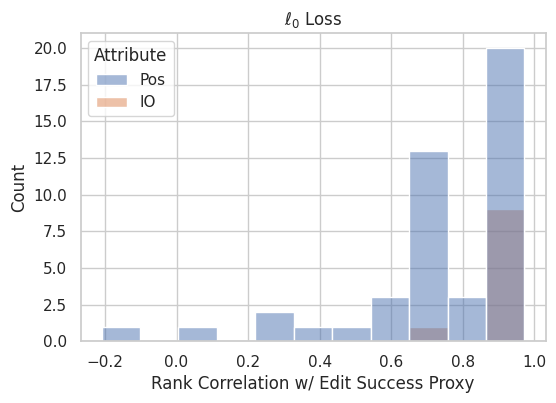

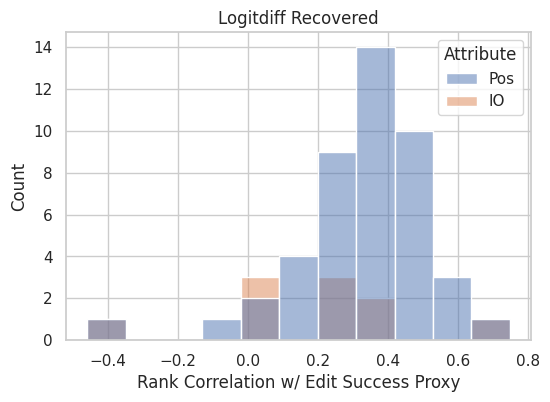

In [201]:
l0_chart = alt.Chart(x_correlation_with_l0_loss).mark_bar().encode(
    x=alt.X('correlation', bin=alt.Bin(maxbins=20)),
    y='count()',
    row='variant',
    column='attribute',
)

ld_chart = alt.Chart(x_correlation_with_ld_loss).mark_bar().encode(
    x=alt.X('correlation', bin=alt.Bin(maxbins=20)),
    y='count()',
    row='variant',
    column='attribute',
)

# now in seaborn
for x_df in (x_correlation_with_l0_loss, x_correlation_with_ld_loss):
    x_df['attribute'] = x_df['attribute'].apply(lambda x: 'Pos' if x == 'io_pos' else 'IO')
    x_df.rename(columns={'attribute': 'Attribute', 'correlation': 'Rank Correlation w/ Edit Success Proxy'}, inplace=True)
    
# fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
# sns.histplot(data=x_correlation_with_l0_loss.query('variant == "gated"'), x='Rank Correlation w/ Edit Success Proxy', hue='Attribute', ax=ax[0],)
# ax[0].set_title('Rank Correlation w/ $\ell_0$ Loss')
# sns.histplot(data=x_correlation_with_ld_loss.query('variant == "gated"'), x='Rank Correlation w/ Edit Success Proxy', hue='Attribute', ax=ax[1],)
# ax[1].set_title('Rank Correlation w/ Logitdiff Recovery')
# # save the figure as pdf
# fig.savefig('rank_correlation.pdf')

# re-do the commented code above, but create 2 separate histograms and 2 separate figures
for i, x_df in enumerate([x_correlation_with_l0_loss, x_correlation_with_ld_loss]):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(data=x_df.query('variant == "gated"'), x='Rank Correlation w/ Edit Success Proxy', hue='Attribute', ax=ax,)
    ax.set_title('$\ell_0$ Loss' if i == 0 else 'Logitdiff Recovered')
    ax.set_xlabel('Rank Correlation w/ Edit Success Proxy')
    ax.set_ylabel('Count')
    fig.savefig(f'rank_correlation_{i}.pdf', bbox_inches='tight')

In [ ]:

# now, same plots in seaborn
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

x_correlation_with_l0_loss['Attribute'] = x_correlation_with_l0_loss['attribute'].map(lambda x: 'IO' if x == 'io' else 'Pos')
x_correlation_with_ld_loss['Attribute'] = x_correlation_with_ld_loss['attribute'].map(lambda x: 'IO' if x == 'io' else 'Pos')

sns.histplot(x_correlation_with_l0_loss, x='correlation', hue='Attribute', ax=ax[0])
# set the x, y axis names
ax[0].set_xlabel('Spearman Rank Correlation of $\ell_0$ Loss\n w/ Edit Success')
ax[0].set_ylabel('Number of IOI Circuit Sites')

# now with ld loss
sns.histplot(x_correlation_with_ld_loss, x='correlation', hue='Attribute', ax=ax[1])
# set the x, y axis names
ax[1].set_xlabel('Spearman Rank Correlation of Logitdiff Recovered\n w/ Edit Success')
ax[1].set_ylabel('')



In [56]:
alt.Chart(x).mark_circle(size=100).encode(
    x='l0_loss',
    y='dist_normalized',
    color='attribute',
    column='node',
).properties(width=600, height=600)

alt.Chart(...)

In [ ]:
# same plot in seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=x.query('node == "z@L8H6@end" and attribute == "io_pos"'), x='l0_loss', y='dist_normalized', hue='attribute')
# add a title 
plt.title('L0 loss (x) vs. distance to counterfactual (y, normalized), L8H6')
# hide legend
plt.legend().remove()
# hide x, y axis labels
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
alt.Chart(x.query('ld_loss <= 2')).mark_bar(opacity=0.3).encode(
    x=alt.X('ld_loss', bin=alt.Bin(maxbins=100)),
    y=alt.Y('count()', stack=None),
    color=alt.Color('node', legend=None)).properties(width=800, height=400)


In [ ]:
# now, paint overlapping histograms using seaborn
sns.histplot(pd.DataFrame(corrs).query('attribute == "io"')['corr'], bins=15, color='red', alpha=0.5)
sns.histplot(pd.DataFrame(corrs).query('attribute == "io_pos"')['corr'], bins=15, color='blue', alpha=0.5)
plt.xlabel('Rank Correlation')
plt.ylabel('Frequency')
plt.title('Rank Correlation between LD Loss and L2 Distance')
plt.legend(['io', 'io_pos'])

In [ ]:
x = EDIT_SELECTION_AND_METRICS.query('num_exchange == 2 and dist_method == "l2" and edit_type == "agnostic" and variant == "gated" and end_epoch == 2_000')
x['attribute'] = x['attribute'].map(lambda x: x[0])
x_normalization = x.groupby(['node', 'attribute'])[['ld_loss', 'dist']].mean().reset_index()
x = x.merge(x_normalization, on=['node', 'attribute'], suffixes=('', '_normalization'))
x['dist'] = x['dist'] / x['dist_normalization']
alt.Chart(x).mark_line().encode(
    x='ld_loss',
    y='dist',
    color='attribute',
    detail=['node', 'attribute', ],
)
# now, same plot in seaborn
fig, ax = plt.subplots(figsize=(20, 20))
# use markers for each point on the lines
sns.lineplot(data=x.query('attribute == "io"'), x='ld_loss', y='dist', hue='node', style='node', ax=ax, markers=True)
# hide legend
ax.get_legend().remove()
plt.show()


# Selecting SAEs to use

In [12]:
K_VALUES = (3,)
EDIT_SELECTION_DF = EDIT_SELECTION_DF.query('variant != "topk" or (variant == "topk" and l1_coeff in @K_VALUES)')

In [13]:
### collect the encoder with the best distance for each variant, node, attribute, num_exchange, dist_method by minimizing over l1_coeff and end_epoch
x = EDIT_SELECTION_DF.groupby(['variant', 'edit_type', 'node', 'attribute', 'num_exchange', 'dist_method'])['dist'].idxmin()
# x = EDIT_SELECTION_DF.groupby(['variant', 'edit_type', 'node', 'attribute', 'num_exchange', 'dist_method'])['dist'].min().reset_index()
# now, choose the values of l1_coeff and end_epoch that minimize the distance
EDIT_SELECTION_DF_BEST = EDIT_SELECTION_DF.loc[x]

In [14]:
### we could also just select the last epoch 
EDIT_SELECTION_DF_LAST_EPOCH = EDIT_SELECTION_DF.query('end_epoch == 2000')
y = EDIT_SELECTION_DF_LAST_EPOCH.groupby(['variant', 'edit_type', 'node', 'attribute', 'num_exchange', 'dist_method'])['dist'].idxmin()
EDIT_SELECTION_DF_LAST_EPOCH_BEST = EDIT_SELECTION_DF_LAST_EPOCH.loc[y]

In [15]:
SELECTED_SAES_OPTIONS = {}

selected_sae_params = []
for selection_df, selection_method in zip((EDIT_SELECTION_DF_BEST, EDIT_SELECTION_DF_LAST_EPOCH_BEST), ('overall', 'last_epoch')):
    SELECTED_SAES = {}
    node_to_displayname = {node: node.displayname for node in NODES}
    displayname_to_node = {v: k for k, v in node_to_displayname.items()}
    for (variant, edit_type, node_name, l1_coeff, end_epoch, attribute, num_exchange, dist_method, _) in tqdm(selection_df.itertuples(index=False)):
        node = displayname_to_node[node_name]
        SELECTED_SAES[(variant, edit_type, node, attribute, num_exchange, dist_method)] = (SAES_DICT[(variant, node, l1_coeff, end_epoch)], l1_coeff, end_epoch)
        selected_sae_params.append({
            'variant': variant,
            'edit_type': edit_type,
            'node': node_name,
            'l1_coeff': l1_coeff,
            'end_epoch': end_epoch,
            'attribute': attribute,
            'num_exchange': num_exchange,
            'dist_method': dist_method,
            'selection_method': selection_method,
        })
    SELECTED_SAES_OPTIONS[selection_method] = SELECTED_SAES

selected_sae_params_df = pd.DataFrame(selected_sae_params)

6160it [00:00, 125828.71it/s]
6160it [00:00, 11806.37it/s]


In [16]:
x = ('io',)
EDIT_SELECTION_DF_LAST_EPOCH_BEST.query(f'variant == "topk" and num_exchange == 2 and dist_method == "l2" and edit_type == "interp"').sort_values('attribute')[:55].l1_coeff.value_counts()

l1_coeff
3.0    55
Name: count, dtype: int64

# Computing supervised features

In [17]:
with storage:
    SUPERVISED_FEATURES_DICT = {}
    SUPERVISED_RECONSTRUCTIONS_DICT = {}
    for node, A in tqdm(A_TRAIN_DICT.items()):
        for eventually in ['independent',]: # 'coupled', 'names', ]:
            for codes_type in ('mean',):  # 'mse'):
                node_parametrization = get_parametrization(node=node, eventually=eventually, use_names= (eventually == 'names'))
                node_features = FEATURE_CONFIGURATIONS[node_parametrization]
                code_getter = get_mean_codes if codes_type == 'mean' else lambda features, A, prompts: train_mse_codes(features=features, A=A, prompts=prompts, manual_bias=True)
                codes, reconstructions = code_getter(
                    features=node_features,
                    A=A,
                    prompts=P_train,
                )
                SUPERVISED_FEATURES_DICT[(node, node_parametrization, codes_type)] = codes
                SUPERVISED_RECONSTRUCTIONS_DICT[(node, node_parametrization, codes_type)] = reconstructions

100%|██████████| 55/55 [00:01<00:00, 44.37it/s]


In [18]:
def get_manual_sae_feature_weights(reconstructions_decomposed: Dict[Tuple[str,...], Tensor]) -> Dict[Tuple[str,...], Tensor]:
    means = reconstructions_decomposed[('bias',)]
    reconstructions = sum(reconstructions_decomposed.values())
    r = reconstructions - means
    r_norms = r.norm(dim=1)
    feature_weights = {k: einsum('batch dim, batch dim -> batch', reconstructions_decomposed[k], r)
                       / r_norms**2 for k in reconstructions_decomposed.keys() if k != ('bias',)}
    for feature_subset in FEATURE_SUBSETS:
        if feature_subset not in feature_weights.keys():
            feature_weights[feature_subset] = sum(feature_weights[(k,)] for k in feature_subset if (k, ) in feature_weights.keys())
    return feature_weights

reconstructions_dict_edit_decomposed = joblib.load('reconstructions_dict_edit_decomposed.joblib')
feature_weights_manual_dict = {}
for node in NODES:
    parametrization = get_parametrization(node, eventually='independent')
    reconstructions_decomposed = reconstructions_dict_edit_decomposed[node, parametrization, 'mean']
    feature_weights = get_manual_sae_feature_weights(reconstructions_decomposed)
    feature_weights_manual_dict[node] = feature_weights

## Finding SAE features most similar to the supervised ones

In [219]:
cosine_sims_rows = []
for node in A_TRAIN_DICT.keys():
    for features in [('io',), ('io_pos',)]:
        for variant in ('gated', 'vanilla', 'topk'):
            attribute = features[0]
            heads_class = NODE_TO_HEADS_CLASS[node]
            if (attribute == 'io_pos' and heads_class in HEAD_CLASSES_POS) or (attribute == 'io' and heads_class in HEAD_CLASSES_IO):
                best_encoder = SELECTED_SAES_OPTIONS['last_epoch'][variant, 'agnostic', node, (attribute,), 2, 'l2'][0]
                best_encoder = storage.unwrap(best_encoder)
                parametrization = get_parametrization(node, eventually='independent', use_names=False)
                supervised_features = storage.unwrap(SUPERVISED_FEATURES_DICT[node, parametrization, 'mean'])[(attribute,)]
                supervised_features_normalized = supervised_features / supervised_features.norm(dim=1, keepdim=True)
                best_cosine_sims = einsum('hidden dim, names dim -> hidden names', best_encoder.W_dec, supervised_features_normalized).max(dim=1).values
                # print(best_cosine_sims.mean().item())
                cosine_sims_rows.append({
                    'node': node.displayname,
                    'variant': variant,
                    'attribute': attribute,
                    'cosine_sim': best_cosine_sims.mean().item(),
                })
cosine_sims_df = pd.DataFrame(cosine_sims_rows)

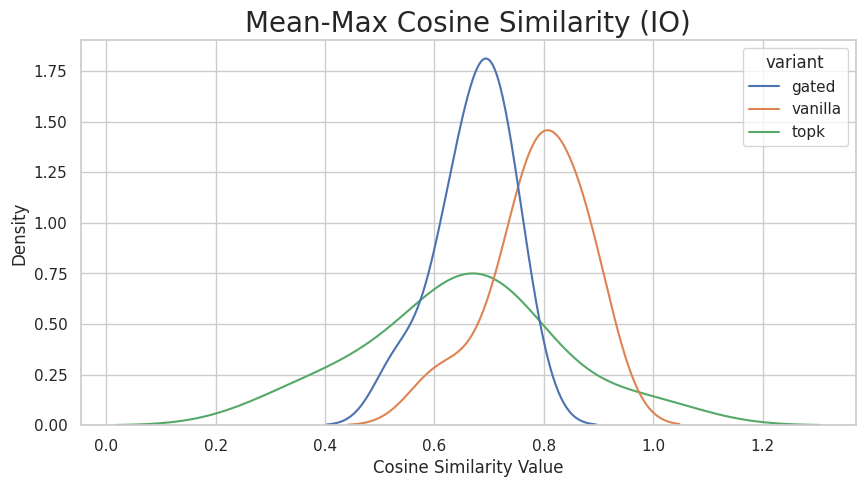

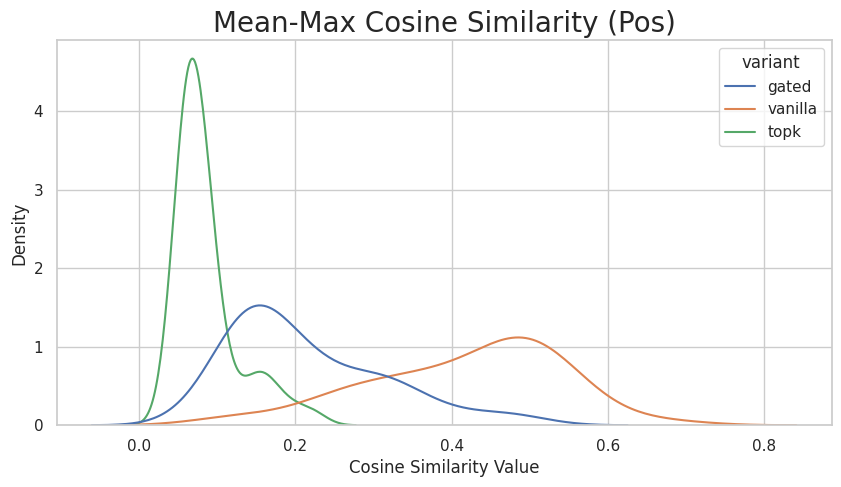

In [231]:
# density plots of cosine_sims using seaborn

# combine the 'variant' and 'attribute' columns
cosine_sims_df['SAE Variant & Attribute'] = cosine_sims_df['variant'] + ', ' + cosine_sims_df['attribute'].apply(lambda x: "IO" if x == "io" else "Pos")
for attribute in ('io', 'io_pos'):
    attribute_displayname = 'IO' if attribute == 'io' else 'Pos'
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.kdeplot(data=cosine_sims_df.query(f'attribute == "{attribute}"'), x='cosine_sim', hue='variant', ax=ax, )
    # plt.title(f'Mean-Max Cosine Similarity ({attribute_displayname})')
    # increase title font size
    plt.title(f'Mean-Max Cosine Similarity ({attribute_displayname})', fontsize=20)
    # change the x-axis name
    plt.xlabel('Cosine Similarity Value')
    plt.show()
    # save the figure as pdf
    fig.savefig(f'cosine_sims_{attribute}.pdf', bbox_inches='tight')

In [64]:
cosine_sims_df.query('variant == "topk" and attribute == "io"')

,node,variant,attribute,cosine_sim,SAE Variant & Attribute
2,z@L9H9@end,topk,io,0.752550,"topk, IO"
5,z@L9H6@end,topk,io,0.750282,"topk, IO"
8,z@L10H0@end,topk,io,0.892832,"topk, IO"
11,z@L9H0@end,topk,io,0.530905,"topk, IO"
14,z@L9H7@end,topk,io,0.344414,"topk, IO"
17,z@L10H1@end,topk,io,0.646167,"topk, IO"
20,z@L10H2@end,topk,io,0.653413,"topk, IO"
23,z@L10H10@end,topk,io,0.585563,"topk, IO"
26,z@L11H2@end,topk,io,0.547762,"topk, IO"
29,z@L11H9@end,topk,io,0.465146,"topk, IO"


<Axes: >

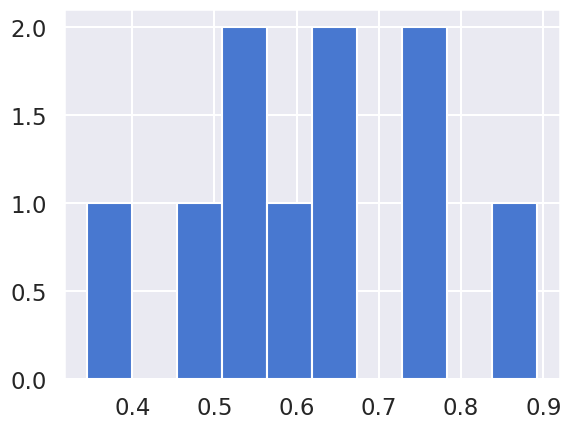

In [60]:
cosine_sims_df.query('variant == "topk" and attribute == "io"').cosine_sim.hist()

In [ ]:
supervised_features.shape, best_encoder.W_dec.shape

In [ ]:
len(SUPERVISED_FEATURES_DICT.keys())

In [ ]:
sup_nodes = [node for node, _, _ in SUPERVISED_FEATURES_DICT.keys()]

node in sup_nodes

# Running the edits

In [19]:
selected_sae_params_df.query('variant == "topk"').l1_coeff.value_counts()

l1_coeff
3.0    1760
Name: count, dtype: int64

In [20]:
### the actual interventions
locations_to_edit = paper_cross_sections

def get_lds(logits: Tensor) -> np.ndarray:
    return (storage.unwrap(logits)[:, 0] - storage.unwrap(logits)[:, 1]).cpu().numpy()

def stringify_nodes(nodes: List[Node]) -> str:
    return ', '.join([node.displayname for node in nodes])

rows = []
rows_weight_removed_supervised = [] # lol...
NUM_EXCHANGE_VALUES = [0, 2] # [0, 2, 4, 8, 16]

with storage:
    for selection_method in ('overall', 'last_epoch'):
        SELECTED_SAES = SELECTED_SAES_OPTIONS[selection_method]
        for nodes_to_edit, feature_subset_to_edit, heads_class in tqdm(locations_to_edit):
            cf_activations = {node: A_EVAL_CF_DICT[feature_subset_to_edit][node] for node in nodes_to_edit}
            cf_prompts = CF_PROMPTS_DICT[feature_subset_to_edit]
            nodes_order = sorted(nodes_to_edit, key=lambda node: node.displayname)
            
            correct_predictions_base = model.to_tokens([f' {p.io_name}' for p in storage.unwrap(P_eval)])[:, 1]
            correct_predictions_cf = model.to_tokens([f' {p.io_name}' for p in storage.unwrap(cf_prompts)])[:, 1]

            for num_exchange in NUM_EXCHANGE_VALUES:
                for edit_type in ('agnostic', 'interp'):
                    for variant in ('vanilla', 'gated', 'attribution', 'topk'):
                        for dist_method in ('l2', 'attribution'):
                            if num_exchange in [8, 16] and variant == 'topk':
                                continue
                            if num_exchange != 0:
                                best_encoder_data = {node: SELECTED_SAES[(variant, edit_type, node, feature_subset_to_edit, num_exchange, dist_method)] for node in nodes_to_edit}
                                best_edited_activations = {node: EDITED_DICT[(variant, node, l1_coeff, end_epoch, feature_subset_to_edit, num_exchange, edit_type)]
                                                    for node, (encoder, l1_coeff, end_epoch) in best_encoder_data.items()}
                            else:
                                best_edited_activations = {node: A_EVAL_DICT[node] for node in nodes_to_edit}
                            ### intervention outcome
                            base_logits_edit, thing = run_activation_patch(
                                base_prompts=P_eval,
                                cf_prompts=cf_prompts,
                                batch_size=50,
                                nodes=nodes_order,
                                activations=[best_edited_activations[node] for node in nodes_order],
                                return_predictions=True,
                            )
                            cf_logits_edit, predictions_edit = storage.unwrap(thing)
                            accuracy_edit_base = (predictions_edit == correct_predictions_base).float().mean().item()
                            accuracy_edit_cf = (predictions_edit == correct_predictions_cf).float().mean().item()
                            base_logits_edit, cf_logits_edit = storage.unwrap(base_logits_edit), storage.unwrap(cf_logits_edit)

                            ### baseline (counterfactual patching) outcome
                            base_logits_patch, thing = run_activation_patch(
                                base_prompts=P_eval,
                                cf_prompts=cf_prompts,
                                batch_size=50,
                                nodes=nodes_order,
                                activations=[cf_activations[node] for node in nodes_order],
                                return_predictions=True,
                            )
                            cf_logits_patch, predictions_patch = storage.unwrap(thing)
                            accuracy_patch_base = (predictions_patch == correct_predictions_base).float().mean().item()
                            accuracy_patch_cf = (predictions_patch == correct_predictions_cf).float().mean().item()

                            base_logits_patch, cf_logits_patch = storage.unwrap(base_logits_patch), storage.unwrap(cf_logits_patch)
                            base_lds_edit = get_lds(base_logits_edit)
                            cf_lds_edit = get_lds(cf_logits_edit)
                            base_lds_patch = get_lds(base_logits_patch)
                            cf_lds_patch = get_lds(cf_logits_patch)

                            if num_exchange == 0:
                                removed_weights = [torch.zeros(len(base_logits_edit)).cuda() for _ in nodes_order]
                            else:
                                removed_weights = []
                                for node in nodes_order:
                                    _, l1_coeff, end_epoch = best_encoder_data[node]
                                    removed_weights.append(
                                        WEIGHT_REMOVED_DICT[(variant, node, l1_coeff, end_epoch, feature_subset_to_edit, num_exchange, edit_type)]
                                    )
                            
                            
                            ### get the baseline removed weights
                            baseline_removed_weights = []
                            for node in nodes_order:
                                baseline_removed_weights.append(
                                    feature_weights_manual_dict[node][feature_subset_to_edit]
                                )
                            
                            rows_weight_removed_supervised.append({
                                'nodes_to_edit': stringify_nodes(nodes_to_edit),
                                'heads_class': heads_class,
                                'attribute': feature_subset_to_edit[0],
                                'weight_removed': torch.cat(storage.unwrap(baseline_removed_weights)).nanmean().item(),
                            })

                            ### now, calculate a normalized measure of weight removed
                            weight_removed_affine = 0
                            weight_removed = 0
                            weight_removed_supervised = 0
                            for wr, bwr in zip(removed_weights, baseline_removed_weights):
                                weight_removed_affine += (storage.unwrap(wr) - bwr) / (1 - bwr)
                                weight_removed += storage.unwrap(wr)
                                weight_removed_supervised += bwr
                            weight_removed_affine /= len(removed_weights)
                            weight_removed /= len(removed_weights)
                            weight_removed_supervised /= len(removed_weights)

                            row = {
                                # params
                                'num_exchange': num_exchange,
                                'nodes_to_edit': stringify_nodes(nodes_to_edit),
                                'heads_class': heads_class,
                                'attribute': feature_subset_to_edit[0],
                                'edit_type': edit_type,
                                # 'prompt_idx': list(range(len(base_logits_edit))),
                                'variant': variant,
                                'dist_method': dist_method,
                                'selection_method': selection_method,
                                # agreement between cf predictions and edit predictions
                                'agreement_with_cf': (predictions_edit == predictions_patch).cpu().numpy().mean(),
                                # 'weight_removed_affine': weight_removed_affine.cpu().numpy().mean(),
                                'weight_removed': weight_removed.nanmean().item(),
                                # 'weight_removed_supervised': weight_removed_supervised.cpu().numpy().mean(),
                                # 'removed_weight': torch.cat(removed_weights).cpu().numpy(),
                                # 'baseline_removed_weight': torch.cat(baseline_removed_weights).cpu().numpy(),
                                # weight removed
                                # 'weight_removed_fraction': np.mean(removed_weights),
                            }

                            rows.append(row)
                            storage.commit()
                            storage.atoms.clear()
                            torch.cuda.empty_cache()
df = pd.DataFrame(rows)
supervised_weight_removed_df = pd.DataFrame(rows_weight_removed_supervised)

100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


In [21]:
supervised_df = pd.read_csv('supervised_editing_full_df.csv')
supervised_df['agreement_with_cf'] = supervised_df['predictions_edit'] == supervised_df['predictions_patch']
supervised_df.drop(columns=['method', 'codes_type', 'eventually'], inplace=True)
# restrict to the features we care about
supervised_df = supervised_df[supervised_df.features.apply(lambda x: eval(x)).isin([('io',), ('io_pos',)])]
# average out
supervised_df = supervised_df.groupby(['heads_class', 'features', 'nodes_to_edit'])['agreement_with_cf'].mean().reset_index()
supervised_df['attribute'] = supervised_df['features'].map(lambda x: eval(x)[0])
supervised_df.drop(columns=['features'], inplace=True)
supervised_df = supervised_df.merge(supervised_weight_removed_df.drop_duplicates(), how='inner', on=['nodes_to_edit', 'heads_class', 'attribute'])
supervised_df['variant'] = 'supervised'

In [22]:
final_df = pd.concat([df, supervised_df], ignore_index=True)

In [23]:
PARAMS = ['num_exchange', 'nodes_to_edit', 'attribute', 'edit_type', 'variant', 'dist_method', 'selection_method']
final_df['edit_location'] = final_df.apply(lambda x: get_location(x['nodes_to_edit'], x['attribute']), axis=1)
PARAMS += ['edit_location']

## Plot the weight removed stats

In [24]:
# get a dataframe where we melt the weight removed columns, and similarly for the agreement with cf
query = 'num_exchange == 2 and (variant in ["gated", "vanilla", "topk"] and dist_method == "l2") or (variant == "supervised")'
final_df = final_df.query(query)
query = '(selection_method != "overall") or (variant == "supervised")'
final_df = final_df.query(query)

In [25]:
selected_sae_params_df.query('selection_method == "last_epoch"').end_epoch.value_counts()

end_epoch
2000    6160
Name: count, dtype: int64

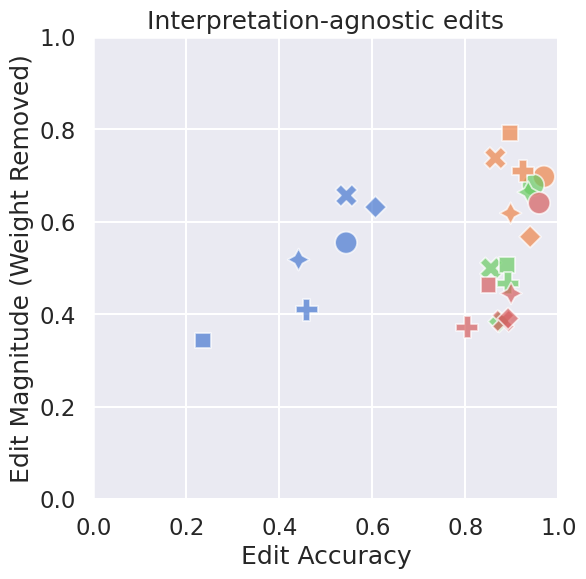

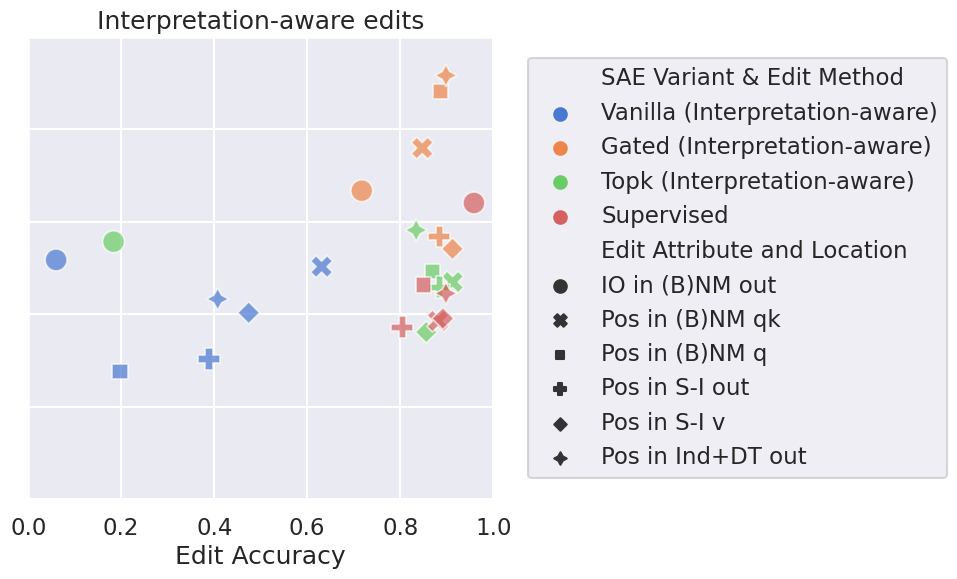

In [35]:
def combine_variant_and_method(variant, method):
    if variant == "supervised":
        return "Supervised"
    else:
        if method == 'agnostic':
            method = 'Interpretation-agnostic'
        elif method == 'interp':
            method = 'Interpretation-aware'
        else:
            raise ValueError(f'Unknown method: {method}')
        return f'{variant.capitalize()} ({method})'

for edit_types in (['agnostic',], ['interp',]):
    final_df['variant_and_method'] = final_df.apply(lambda x: combine_variant_and_method(x['variant'], x['edit_type']), axis=1)
    query = f'(edit_type in {edit_types} or variant == "supervised")'
    displaynames = {
        'variant_and_method': 'SAE Variant & Edit Method',
        'edit_location': 'Edit Attribute and Location',
    }
    for k, v in displaynames.items():
        final_df[v] = final_df[k].copy()

    # now plot lines combining the two metrics
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.scatterplot(data=final_df.query(query), x='agreement_with_cf', y='weight_removed', hue=displaynames['variant_and_method'], ax=ax, 
                style=displaynames['edit_location'], s=250, 
                # increase opacity
                alpha=0.7)
    # set x, y limits to 0-1
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    # set the title
    method_label = "Interpretation-aware" if edit_types == ['interp',] else "Interpretation-agnostic"
    plt.title(f'{method_label} edits')
    # put the legend outside of the plot to the right
    # rename x, y axes
    ax.set_xlabel('Edit Accuracy')
    if edit_types == ['agnostic',]:
        ax.set_ylabel('Edit Magnitude (Weight Removed)')
        # hide the legend
        ax.legend().set_visible(False)
    else:
        ax.set_ylabel('')
        # hide the y ticks without removing the grid lines
        ax.tick_params(axis='y', which='both', length=0)
        ax.set_yticklabels([])
        
        ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    # save the figure 
    plt.savefig(f'editing_acc_vs_magnitude_{method_label}.pdf', bbox_inches='tight')

In [38]:
final_df.selection_method.value_counts()

selection_method
last_epoch    36
Name: count, dtype: int64

In [ ]:
final_df.query('edit_type == "agnostic" or variant == "supervised"')

In [ ]:

# now, do it in seaborn
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=df_weight_removed.query(f'selection_method == "{dropped_selection_method}"'), x='edit_location', y='weight_removed', hue='weight_removed_type', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Weight removed')
plt.show()

# and for agreement with cf
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=df_agreement_with_cf.query(f'selection_method == "{dropped_selection_method}"'), x='edit_location', y='agreement_with_cf', hue='agreement_with_cf_type', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Agreement with CF')
plt.show()

In [ ]:
dropped_selection_method = 'last_epoch'
alt.Chart(df_weight_removed.query(f'selection_method == "{dropped_selection_method}"')).mark_bar().encode(
    column='edit_location',
    y='mean(weight_removed)',
    x='weight_removed_type',
    color='weight_removed_type',
).properties(
    width=50,
    height=400,
) | alt.Chart(df_agreement_with_cf.query(f'selection_method == "{dropped_selection_method}"')).mark_bar().encode(
    column='edit_location',
    y='mean(agreement_with_cf)',
    x='agreement_with_cf_type',
    color='agreement_with_cf_type',
).properties(
    width=50,
    height=400,
)


In [ ]:
df_weight_removed.drop_duplicates()

In [ ]:
# plot a bar chart, where for each `edit_location` we show two bars:
# the value of the `weight_removed_edit` column, and
# the value of the `weight_removed_supervised_edit` column

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    x='edit_location',
    y='weight_removed_edit',
    data=final_df,
    ax=ax,
    color='blue',
    label='Weight removed',
)
sns.barplot(
    x='edit_location',
    y='weight_removed_supervised_edit',
    data=final_df,
    ax=ax,
    color='red',
    label='Weight removed supervised',
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Weight removed')
ax.set_xlabel('Location')
ax.legend()


In [ ]:
alt.Chart(final_df.query('variant == "gated" and edit_type == "agnostic"')).mark_line().encode(
    x='edit_location:O',
    y='weight_removed_edit',
    color='num_exchange:N',
    strokeDash=alt.value([4, 4]),
) + alt.Chart(final_df).mark_line().encode(
    x='edit_location:O',
    y='weight_removed_supervised_edit',
    color='num_exchange:N',
    strokeDash=alt.value([1, 1]),
)

In [ ]:
### now, perform the rescaling
final_df['agreement_score'] = ((final_df['agreement_with_cf_edit'] - final_df['agreement_with_cf_no_intervention']) /
                         (final_df['agreement_with_cf_supervised'] - final_df['agreement_with_cf_no_intervention'])).clip(0, 2)

final_df['score'] = final_df['weight_removed_affine_edit']

In [ ]:
combined_pareto_plot(a=things[0], b=things[1], fname=f'combined', legend=True)